In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns
from math import comb

from main import *

reports_dir = 'reports/'
save_dir = 'images/'

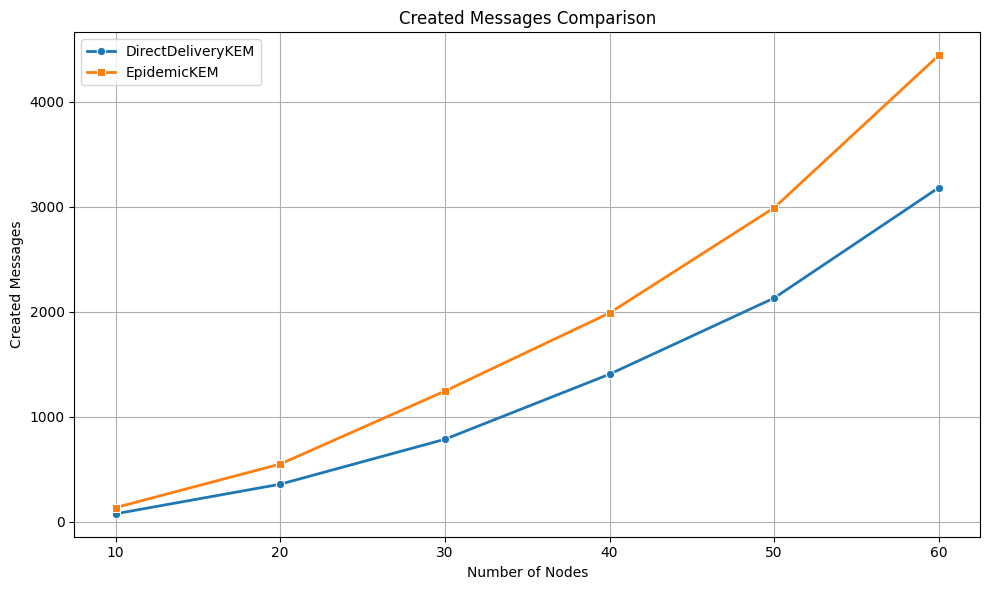

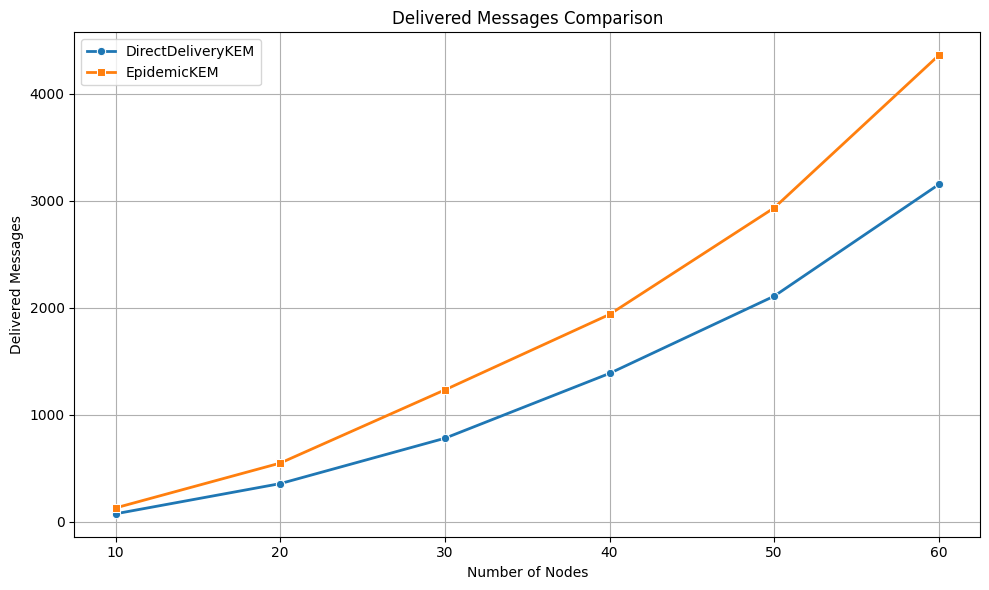

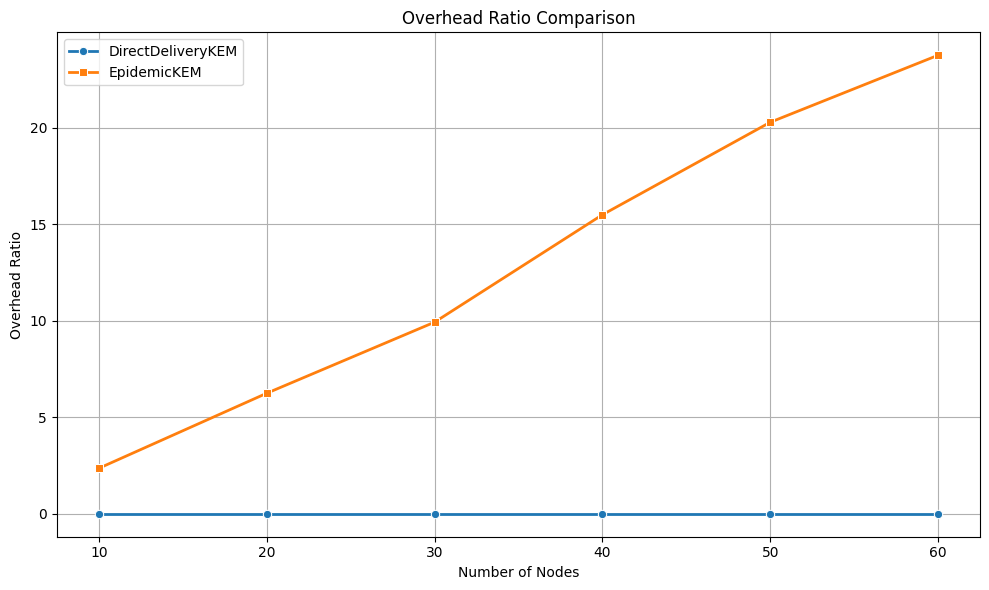

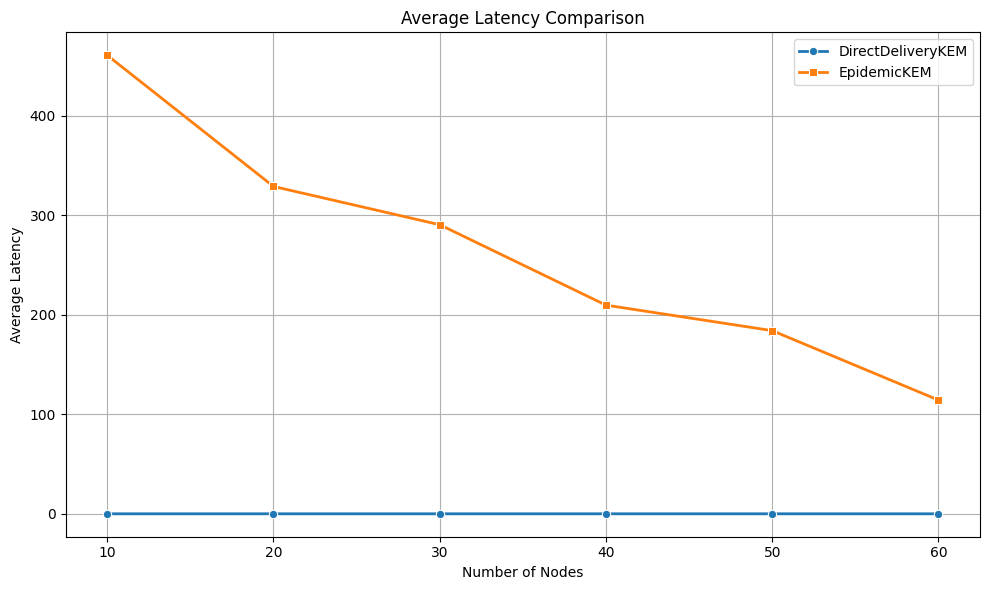

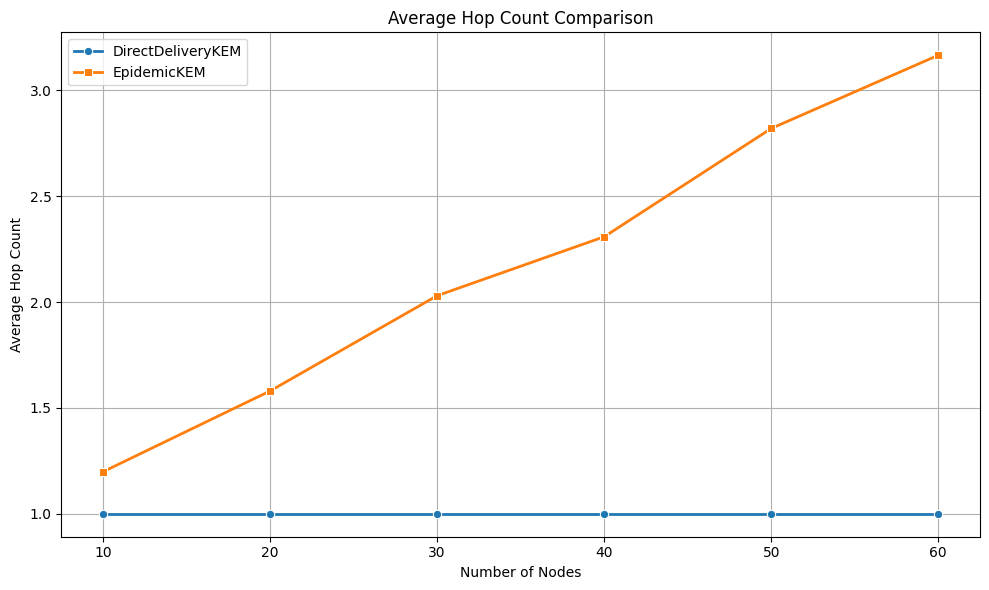

In [21]:
plot_message_field("created", "Created Messages")
plot_message_field("delivered", "Delivered Messages")
plot_message_field("overhead_ratio", "Overhead Ratio")
plot_message_field("latency_avg", "Average Latency")
plot_message_field("hopcount_avg", "Average Hop Count")

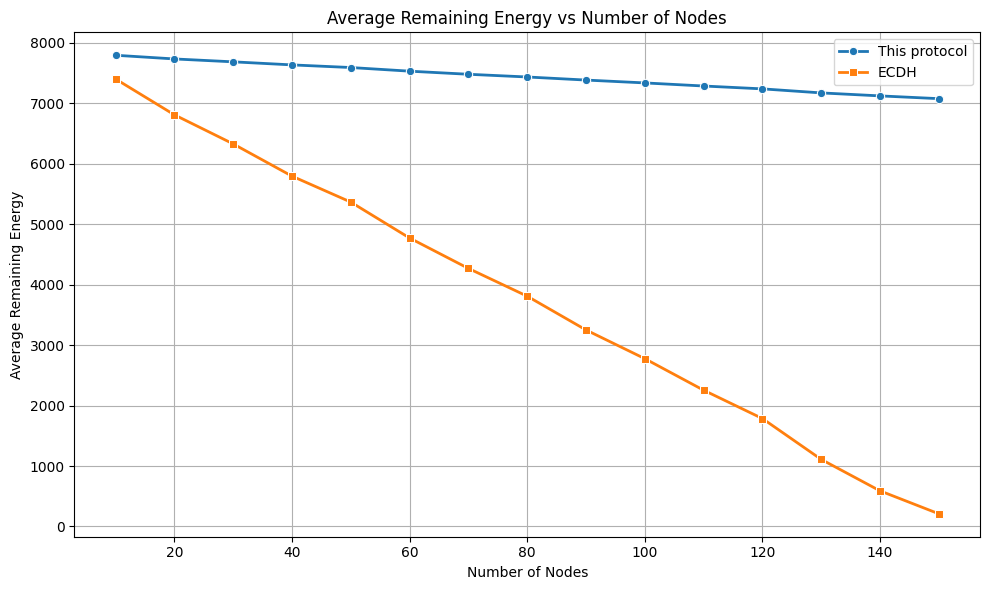

In [22]:
def extract_remaining_energy(filename):
    with open(os.path.join(reports_dir, filename)) as f:
        content = f.read()
        matches = re.findall(r"\[(\d+)\](.*?)\n(?=\[|$)", content, re.DOTALL)
        if not matches:
            return None
        last_frame = matches[-1][1].strip()
        energy_values = [float(line.split()[1]) for line in last_frame.splitlines() if line.strip()]
        return np.mean(energy_values)

direct_energy = {}
ecdh_energy = {}

for file in os.listdir(reports_dir):
    if file.endswith("_EnergyLevelReport.txt"):
        match = re.search(r"_(\d+)_EnergyLevelReport", file)
        if not match:
            continue
        nodes = int(match.group(1))
        avg_energy = extract_remaining_energy(file)
        if "DirectDeliveryKEMRouter" in file:
            direct_energy[nodes] = avg_energy
        elif "ECDHRouter" in file:
            ecdh_energy[nodes] = avg_energy

# Common nodes
node_counts = sorted(set(direct_energy.keys()) & set(ecdh_energy.keys()))
direct_vals = [direct_energy[n] for n in node_counts]
ecdh_vals = [ecdh_energy[n] for n in node_counts]

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=node_counts, y=direct_vals, marker='o', label='This protocol', linewidth=2)
sns.lineplot(x=node_counts, y=ecdh_vals, marker='s', label='ECDH', linewidth=2)

plt.title("Average Remaining Energy vs Number of Nodes")
plt.xlabel("Number of Nodes")
plt.ylabel("Average Remaining Energy")
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.savefig(os.path.join(save_dir, "average_remaining_energy_comparison.png"))
plt.show()

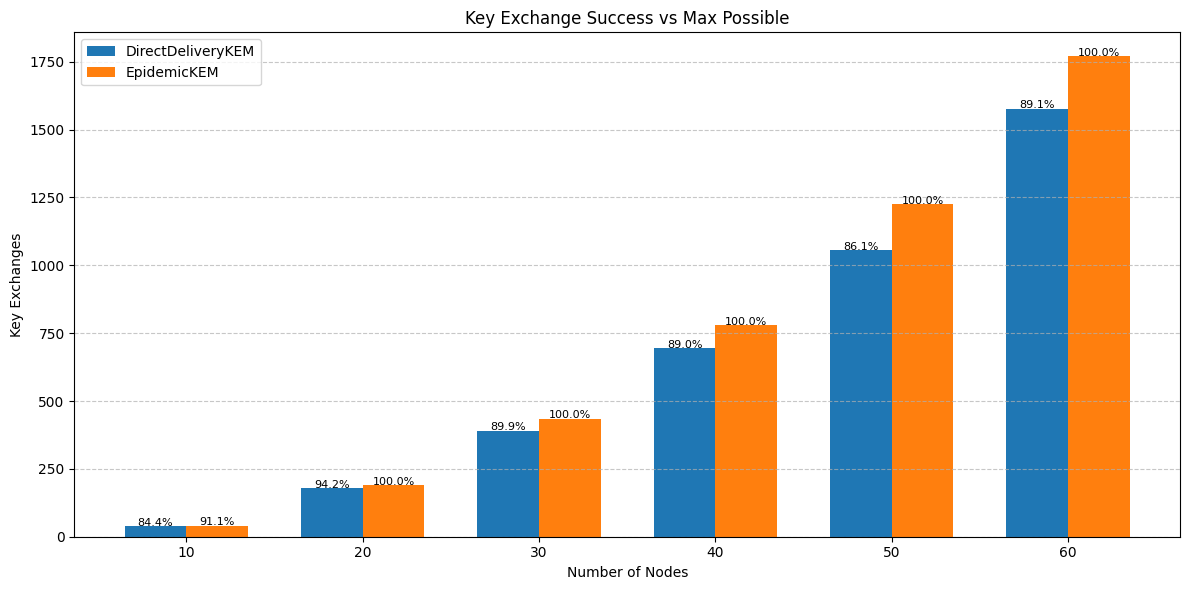

In [23]:
def get_success_count(filepath):
    with open(filepath) as f:
        content = f.read()
        match = re.search(r"Key Exchange Success Count:\s+(\d+)", content)
        return int(match.group(1)) if match else None

# Collect data
dd_data = {}
epidemic_data = {}

for file in os.listdir(reports_dir):
    if not file.endswith("_KeyExchangeRateReport.txt"):
        continue

    match = re.search(r"_(\d+)_KeyExchangeRateReport", file)
    if not match:
        continue
    nodes = int(match.group(1))
    success = get_success_count(os.path.join(reports_dir, file))

    if "DirectDeliveryKEMRouter" in file:
        dd_data[nodes] = success
    elif "EpidemicKEMRouter" in file:
        epidemic_data[nodes] = success

# Filter only common node counts
common_nodes = sorted(set(dd_data) & set(epidemic_data))

# Prepare data
dd_success = [dd_data[n] for n in common_nodes]
epi_success = [epidemic_data[n] for n in common_nodes]
dd_max = [comb(n, 2) for n in common_nodes]
epi_max = dd_max  # same N for both

x = np.arange(len(common_nodes))
width = 0.35

# Plot
plt.figure(figsize=(12, 6))
bar1 = plt.bar(x - width/2, dd_success, width, label='DirectDeliveryKEM')
bar2 = plt.bar(x + width/2, epi_success, width, label='EpidemicKEM')

# Annotate percentage
for i in range(len(common_nodes)):
    dd_percent = dd_success[i] / dd_max[i] * 100
    epi_percent = epi_success[i] / epi_max[i] * 100
    plt.text(x[i] - width/2, dd_success[i] + 1, f"{dd_percent:.1f}%", ha='center', fontsize=8)
    plt.text(x[i] + width/2, epi_success[i] + 1, f"{epi_percent:.1f}%", ha='center', fontsize=8)

# Axes and formatting
plt.xticks(x, common_nodes)
plt.xlabel("Number of Nodes")
plt.ylabel("Key Exchanges")
plt.title("Key Exchange Success vs Max Possible")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig(os.path.join(save_dir, "key_exchange_success.png"))
plt.show()

In [24]:
# def plot_cdf_for_group(prefix):
#     plt.figure(figsize=(10, 6))
#     for file in sorted(os.listdir(reports_dir)):
#         if not file.startswith(prefix) or not file.endswith("MessageDelayReport.txt"):
#             continue

#         # Extract node count
#         node_count = file.split('_')[1]

#         df = pd.read_csv(os.path.join(reports_dir, file), sep=" ", comment='#', names=["delay", "cdf"])
#         plt.plot(df['delay'], df['cdf'], label=f'{node_count} nodes')

#     plt.xlabel("Message Delay (s)")
#     plt.ylabel("Cumulative Probability")
#     plt.title(f"Message Delay CDF – {prefix}")
#     plt.legend(title="Nodes", bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.grid(True)
#     plt.tight_layout()
#     plt.savefig(os.path.join(save_dir, f'{prefix}_delay_cdf.png'))
#     plt.show()

# plot_cdf_for_group("EpidemicKEMRouter")

In [25]:
# scenarios = [
#     "DirectDeliveryKEMRouter_50_MessageDelayReport.txt",
#     "EpidemicKEMRouter_50_MessageDelayReport.txt"
# ]

# plt.figure(figsize=(10, 6))
# for file in scenarios:
#     label = file.split('_')[0]
#     df = pd.read_csv(os.path.join(reports_dir, file), sep=" ", comment='#', names=["delay", "cdf"])
#     plt.plot(df['delay'], df['cdf'], label=label)

# plt.xlabel("Message Delay (s)")
# plt.ylabel("Cumulative Probability")
# plt.title("Message Delay CDF @ 50 Nodes")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.savefig(os.path.join(save_dir, 'compare_delay_50nodes.png'))
# plt.show()